# 3. Product Category Clustering

This notebook covers:
- Analyzing product categories in the dataset
- Generating text embeddings for product names/categories
- Clustering into 4–6 meta-categories
- Evaluating and visualizing the clusters

**Example meta-categories (from README):**
- Ebook readers
- Batteries
- Accessories (keyboards, laptop stands, etc.)
- Non-electronics (Nespresso pods, pet carriers, etc.)

## 3.1 Imports & Setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

c:\Users\bruno\Desktop\Ironhack\labs\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Libraries imported successfully.


## 3.2 Load Data

In [2]:
df = pd.read_csv('data/preprocessed_reviews.csv')
print(f"Loaded {df.shape[0]} reviews")
df.head()

Loaded 28232 reviews


,name,primaryCategories,reviews.text,reviews.rating,reviews.title,clean_text,sentiment,review_length
0,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,I order 3 of them and one of the item is bad q...,3,... 3 of them and one of the item is bad quali...,order one item bad quality missing backup spri...,Neutral,14
1,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Bulk is always the less expensive way to go fo...,4,... always the less expensive way to go for pr...,bulk always less expensive way product like,Positive,7
2,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Well they are not Duracell but for the price i...,5,... are not Duracell but for the price i am ha...,well duracell price happy,Positive,4
3,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Seem to work as well as name brand batteries a...,5,... as well as name brand batteries at a much ...,seem work well name brand battery much better ...,Positive,9
4,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,These batteries are very long lasting the pric...,5,... batteries are very long lasting the price ...,battery long lasting price great,Positive,5


## 3.3 Explore Product Categories

In [ ]:
# Inspect unique product names/categories
print(f"Unique products: {df['name'].nunique()}")
print(df['name'].value_counts().head(20))

Unique products: 65
name
AmazonBasics AAA Performance Alkaline Batteries (36 Count)                                                                                      8279
AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary                                                                  3692
Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers                                                               2443
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black                                                           2370
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case                                                                          1676
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                                                                          1425
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case          

## 3.4 Generate Embeddings

Embeddings will be generated for product names and categories to capture semantic similarities.

In [5]:
# Use a sentence transformer to embed product names
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Get unique product names and generate embeddings
products = df['name'].unique().tolist()
embeddings = embedding_model.encode(products, show_progress_bar=True)
print(f"Embeddings shape: {embeddings.shape}")

Batches: 100%|██████████| 3/3 [00:00<00:00,  4.53it/s]

Embeddings shape: (65, 384)


## 3.5 Find Optimal Number of Clusters

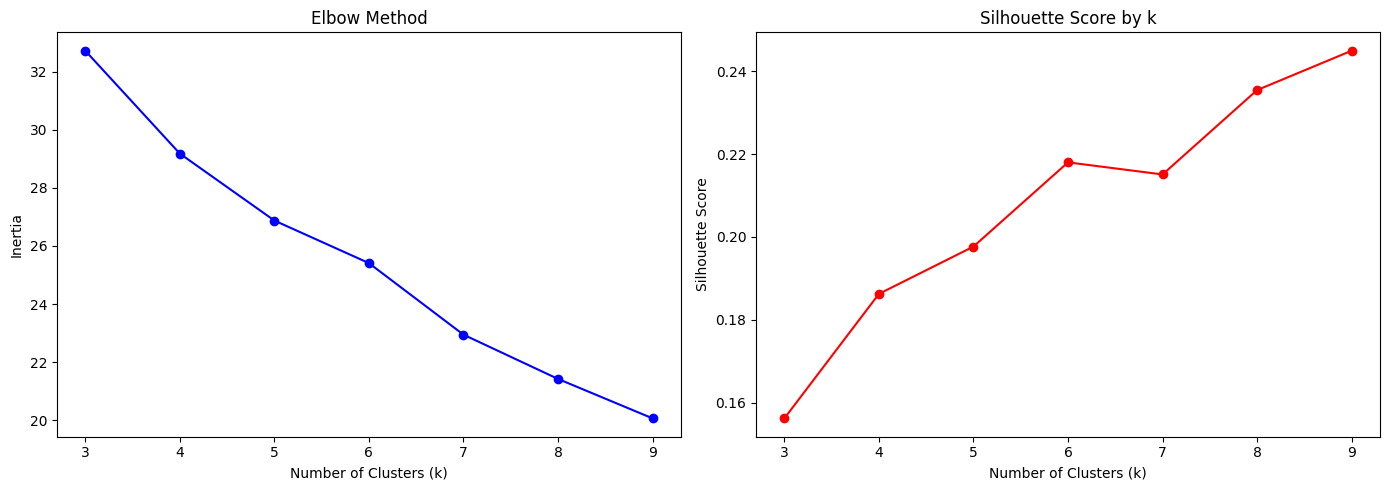

In [6]:
# Elbow method + Silhouette score
inertias = []
silhouette_scores = []
K_range = range(3, 10)

for k in K_range:
 kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
 labels = kmeans.fit_predict(embeddings)
 inertias.append(kmeans.inertia_)
 silhouette_scores.append(silhouette_score(embeddings, labels))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')

ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score by k')

plt.tight_layout()
plt.show()

The elbow method and silhouette scores can help determine the optimal number of clusters.

The elbow method looks for a point where adding more clusters doesn't significantly reduce the within-cluster sum of squares (inertia).

Silhouette scores measure how similar an object is to its own cluster compared to other clusters, with higher scores indicating better-defined clusters.

## 3.6 Clustering (KMeans)

This section will apply KMeans clustering to group products into meta-categories based on their embeddings.

In [19]:
N_CLUSTERS = 5

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

# Create mapping: product -> cluster
product_cluster_map = dict(zip(products, cluster_labels))

# Assign clusters back to full dataframe
df['cluster'] = df['name'].map(product_cluster_map)
print(df['cluster'].value_counts())

cluster
1    14405
4    12033
3     1049
2      643
0      102
Name: count, dtype: int64


## 3.7 Analyze & Name Clusters

We will analyze the products in each cluster to identify common themes and assign descriptive names to the meta-categories.

In [20]:
# Inspect products in each cluster to assign meaningful names
for c in range(N_CLUSTERS):
    cluster_products = [p for p, cl in product_cluster_map.items() if cl == c]
    print(f"\n=== Cluster {c} ({len(cluster_products)} products) ===")
    for p in cluster_products[:10]:
        print(f"  - {p}")


=== Cluster 0 (15 products) ===
  - AmazonBasics Nylon CD/DVD Binder (400 Capacity)
  - AmazonBasics Ventilated Adjustable Laptop Stand
  - AmazonBasics Backpack for Laptops up to 17-inches
  - AmazonBasics 11.6-Inch Laptop Sleeve
  - AmazonBasics 15.6-Inch Laptop and Tablet Bag
  - AmazonBasics External Hard Drive Case
  - Expanding Accordion File Folder Plastic Portable Document Organizer Letter Size
  - Cat Litter Box Covered Tray Kitten Extra Large Enclosed Hooded Hidden Toilet
  - AmazonBasics Silicone Hot Handle Cover/Holder - Red
  - AmazonBasics USB 3.0 Cable - A-Male to B-Male - 6 Feet (1.8 Meters)

=== Cluster 1 (22 products) ===
  - Fire TV Stick Streaming Media Player Pair Kit
  - All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Black
  - Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Pink Kid-Proof Case
  - All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes Special Offers, Magenta
  - All-New Fire HD 8 Tablet, 8 HD Display, 

In [21]:
# Assign human-readable meta-category names
cluster_name_map = {
     0: 'Accessories',
     1: 'Tablets',
     2: 'Smart Assistants',
     3: 'E-Readers',
     4: 'Batteries and Chargers'
}
df['meta_category'] = df['cluster'].map(cluster_name_map)

## 3.8 Visualization

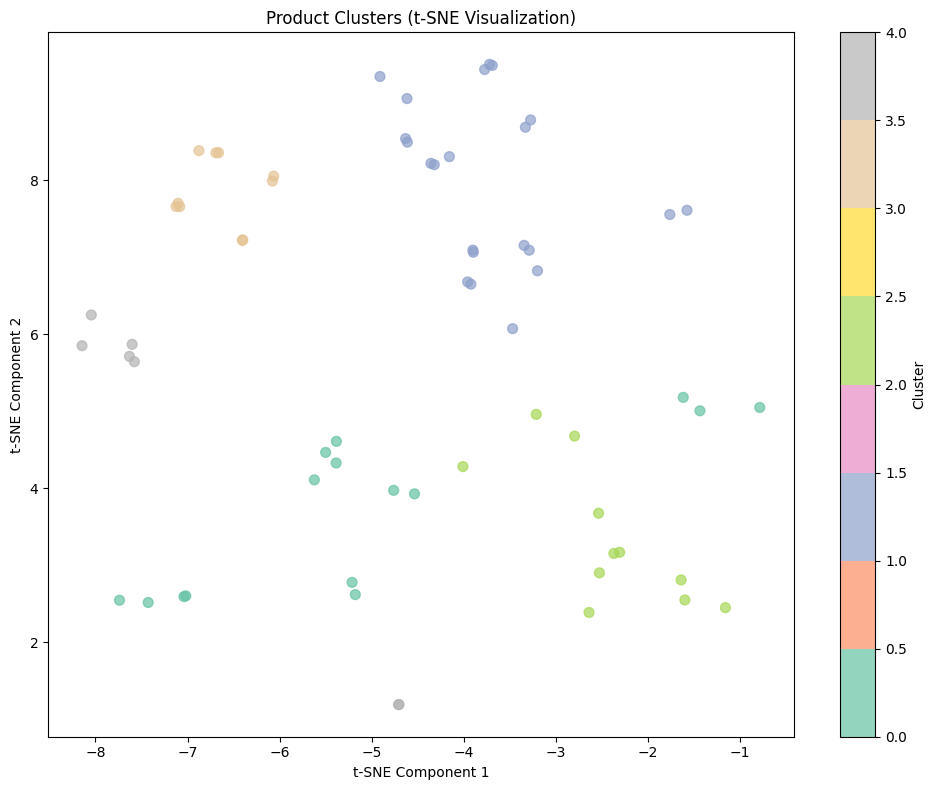

In [22]:
# Reduce embeddings to 2D with t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(products) - 1))
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                      c=cluster_labels, cmap='Set2', alpha=0.7, s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('Product Clusters (t-SNE Visualization)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()

## 3.9 Save Clustered Data

In [23]:
df.to_csv('data/clustered_reviews.csv', index=False)
print(f"Saved clustered data: {df.shape[0]} rows")

Saved clustered data: 28232 rows
